# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

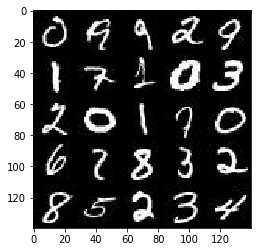

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

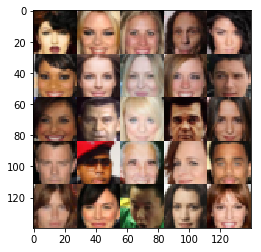

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
# NOTE: I'm adding alpha to the method signature here to use leaky relu
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 4x4x256 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import matplotlib.pyplot as pyplt

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 50
    show_every = 100
    # TODO: Build Model
    input_real, input_z, lr_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Train
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                transformed_batch = batch_images * 2.0 # scale from [-0.5, 0.5] to [-1.0, 1.0]

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: transformed_batch, input_z: batch_z, lr_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_placeholder: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: transformed_batch, lr_placeholder: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr_placeholder: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 8.1306
Epoch 1/2... Discriminator Loss: 0.1278... Generator Loss: 5.5187
Epoch 1/2... Discriminator Loss: 2.8561... Generator Loss: 7.7312
Epoch 1/2... Discriminator Loss: 2.8026... Generator Loss: 0.0709
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 0.5477... Generator Loss: 5.3924
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.2997
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 9.2987
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 0.8190


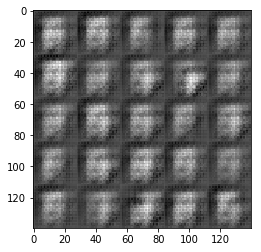

Epoch 1/2... Discriminator Loss: 0.3092... Generator Loss: 5.2787
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 2.0530
Epoch 1/2... Discriminator Loss: 0.3525... Generator Loss: 5.2536
Epoch 1/2... Discriminator Loss: 0.3350... Generator Loss: 3.0829
Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.3384
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 4.2633
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 0.4489... Generator Loss: 2.2383
Epoch 1/2... Discriminator Loss: 0.3039... Generator Loss: 1.7872
Epoch 1/2... Discriminator Loss: 1.5568... Generator Loss: 0.3497


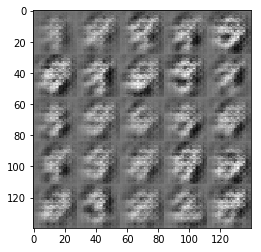

Epoch 1/2... Discriminator Loss: 0.5594... Generator Loss: 2.3478
Epoch 1/2... Discriminator Loss: 2.3850... Generator Loss: 0.2421
Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 2.3313
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 1.6684
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.4560
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 3.6225
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.3979


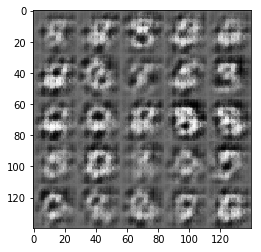

Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 1.9122
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 1.5125
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 2.9876
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 1.4489
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.7086
Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 1.4815


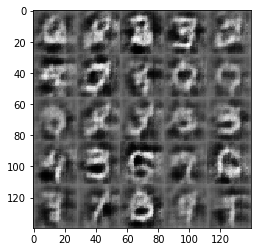

Epoch 1/2... Discriminator Loss: 0.6351... Generator Loss: 1.4266
Epoch 1/2... Discriminator Loss: 0.6982... Generator Loss: 1.6411
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 5.2649
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 2.6673
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.5342
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.8193
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.2048
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.5704


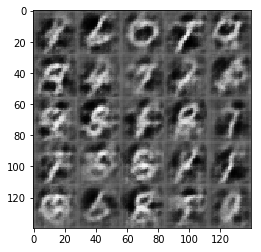

Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 0.9672
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 2.6544
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 0.8413... Generator Loss: 1.4449
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 2.8800
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 3.0515
Epoch 2/2... Discriminator Loss: 0.5707... Generator Loss: 1.4707
Epoch 2/2... Discriminator Loss: 0.7837... Generator Loss: 0.9102
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 2.8236


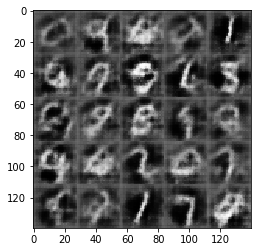

Epoch 2/2... Discriminator Loss: 0.5135... Generator Loss: 1.8932
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 2.6377
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 1.4006
Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.3042
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 2.1558
Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 0.8425


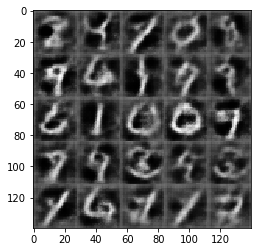

Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 1.4276
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 2.2808
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 1.6168
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 2.1221
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 0.8981


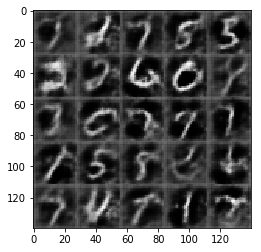

Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.3797
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 1.4777
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.4797
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 2.5083
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.4275
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 0.5355... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 1.0228


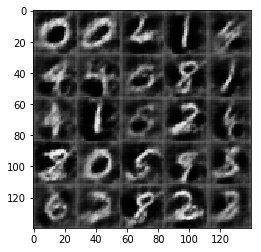

Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 4.1103
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.8447... Generator Loss: 0.3578


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 7.8447
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 5.3886
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 2.3160... Generator Loss: 6.1219
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 2.0479
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 3.4397
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 5.3935
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 1.4121


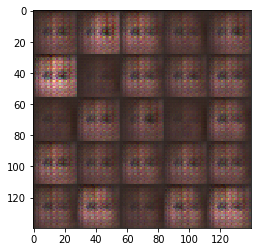

Epoch 1/1... Discriminator Loss: 2.0654... Generator Loss: 9.6040
Epoch 1/1... Discriminator Loss: 0.3176... Generator Loss: 3.0761
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 4.0762
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 3.3826
Epoch 1/1... Discriminator Loss: 2.4124... Generator Loss: 6.9056
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 2.7527
Epoch 1/1... Discriminator Loss: 1.9305... Generator Loss: 7.6536
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 6.4221
Epoch 1/1... Discriminator Loss: 2.9170... Generator Loss: 0.0689
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.6211


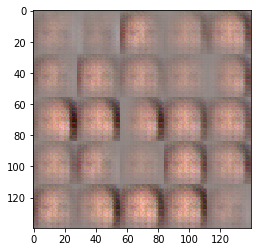

Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 3.7522
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 5.2169
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.8954


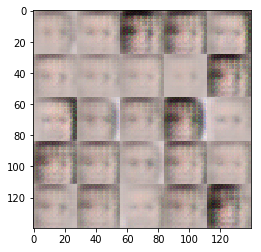

Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 2.8513... Generator Loss: 4.7206
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 2.7420
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.8571


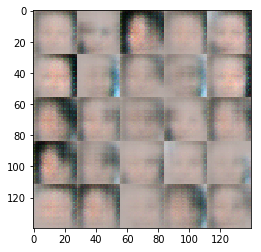

Epoch 1/1... Discriminator Loss: 2.3066... Generator Loss: 2.4576
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 2.4954... Generator Loss: 0.1540
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 4.6769
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 1.7592


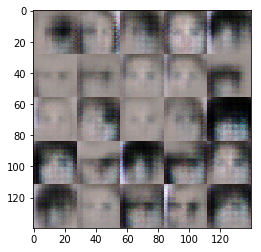

Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.8036
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 1.7611
Epoch 1/1... Discriminator Loss: 2.5862... Generator Loss: 5.2904
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 2.2806
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 0.2739... Generator Loss: 4.0830
Epoch 1/1... Discriminator Loss: 2.1726... Generator Loss: 0.1523
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.2213


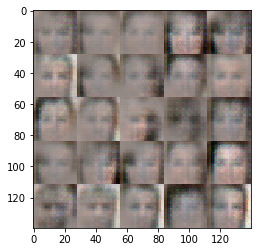

Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.6347
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 1.7689
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.1070
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.9440
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 1.5740


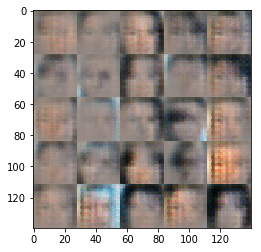

Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 2.8662
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.5983
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.6803


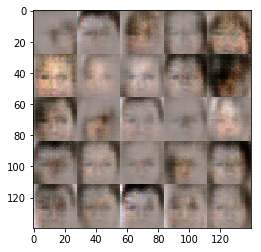

Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 2.9068
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 2.3796
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 1.6487


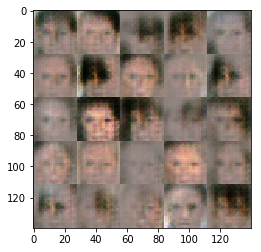

Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 2.0127
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.7013
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 3.9571
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 3.7256
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 1.9532
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.0978
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 2.8613
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.6328


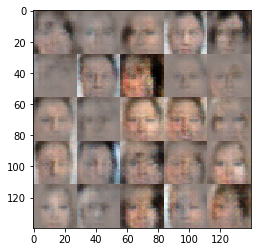

Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.7756
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 2.7201
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 5.3050
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 2.5103
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.7892
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.4276


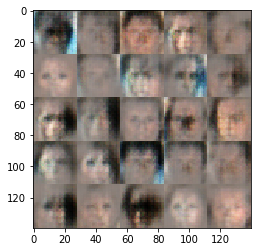

Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.7127
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 1.6649
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 3.9347
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 1.5549
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 2.2922
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.7317
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 3.0339


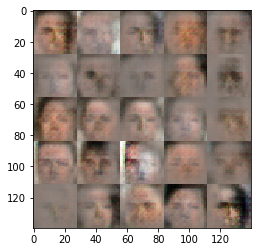

Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.8440
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 3.4366
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 2.0191
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.8488


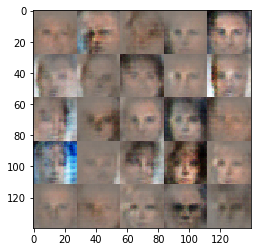

Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 1.9838
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 2.5700
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.4546
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 2.4115
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 2.1665


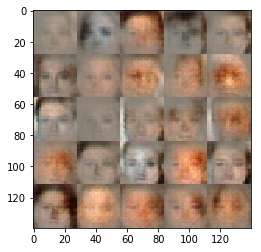

Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.3075... Generator Loss: 2.2058
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 3.0433
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 3.1050
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 3.2136
Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.0643


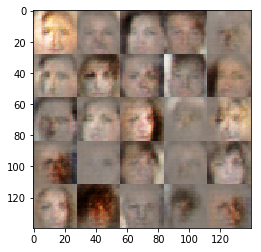

Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 2.0150
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 1.9088
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 2.6977
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 2.9476
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 4.5612
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 4.9679
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 2.3141


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.